In [0]:
# Check GPU on Google Colab
# !nvidia-smi

from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

In [2]:
!pip3 install torch torchvision

In [0]:
#import torch
#torch.__version__
#torch.cuda.is_available()

In [4]:
!pip install -U gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.7.1)


In [5]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk import word_tokenize, sent_tokenize 

In [0]:
from collections import namedtuple

import numpy as np
from tqdm import tqdm

import pandas as pd

from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})


torch.manual_seed(42)

In [0]:
import json

In [0]:
# Read data
# text = open('pickup_lines_all.txt', 'r', encoding = "utf8").read().splitlines()

In [0]:
text = open('1400-0-clean.txt', 'r', encoding = "utf8").read()

In [12]:
text[0:5]

'\ufeffChap'

In [0]:
# Tokenize the text.
tokenized_text = [list(map(str.lower, word_tokenize(word))) for word in sent_tokenize(text)]

In [0]:
class PickupLines(Dataset):
    def __init__(self, texts):
        self.texts = texts
        
        # Initialize the vocab 
        special_tokens = {'<pad>': 0, '<unk>':1, '<s>':2, '</s>':3}
        self.vocab = Dictionary(texts)
        self.vocab.patch_with_special_tokens(special_tokens)
        
        # Keep track of the vocab size.
        self.vocab_size = len(self.vocab)
        
        # Keep track of how many data points.
        self._len = len(texts)
        
        # Find the longest text in the data.
        self.max_len = max(len(txt) for txt in texts) 
        
    def __getitem__(self, index):
        vectorized_sent = self.vectorize(self.texts[index])
        x_len = len(vectorized_sent)
        # To pad the sentence:
        # Pad left = 0; Pad right = max_len - len of sent.
        pad_dim = (0, self.max_len - len(vectorized_sent))
        vectorized_sent = F.pad(vectorized_sent, pad_dim, 'constant')
        return {'x':vectorized_sent[:-1], 
                'y':vectorized_sent[1:], 
                'x_len':x_len}
    
    def __len__(self):
        return self._len
    
    def vectorize(self, tokens, start_idx=2, end_idx=3):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        # Lets just cast list of indices into torch tensors directly =)
        
        vectorized_sent = [start_idx] + self.vocab.doc2idx(tokens) + [end_idx]
        return torch.tensor(vectorized_sent)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [0]:
pickuplines_data = PickupLines(tokenized_text)

In [16]:
len(pickuplines_data.vocab)

11787

In [0]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers):
        super(Generator, self).__init__()

        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        
        # Initialize the GRU with the 
        # - size of the input (i.e. embedding layer)
        # - size of the hidden layer 
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize the "classifier" layer to map the RNN outputs
        # to the vocabulary. Remember we need to -1 because the 
        # vectorized sentence we left out one token for both x and y:
        # - size of hidden_size of the GRU output.
        # - size of vocabulary
        self.classifier = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs, use_softmax=False, hidden=None):
        # Look up for the embeddings for the input word indices.
        embedded = self.embedding(inputs)
        # Put the embedded inputs into the GRU.
        output, hidden = self.gru(embedded, hidden)
        
        # Matrix manipulation magic.
        batch_size, sequence_len, hidden_size = output.shape
        # Technically, linear layer takes a 2-D matrix as input, so more manipulation...
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)
        # Apply dropout.
        output = F.dropout(output, 0.5)
        # Put it through the classifier
        # And reshape it to [batch_size x sequence_len x vocab_size]
        output = self.classifier(output).view(batch_size, sequence_len, -1)
        
        return (F.softmax(output,dim=2), hidden) if use_softmax else (output, hidden)
        

In [0]:
# Training routine.
def train(num_epochs, dataloader, model, criterion, optimizer):
    losses = []
    plt.ion()
    for _e in range(num_epochs):
        for batch in tqdm(dataloader):
            # Zero gradient.
            optimizer.zero_grad()
            x = batch['x'].to(device)
            x_len = batch['x_len'].to(device)
            y = batch['y'].to(device)
            # Feed forward. 
            output, hidden = model(x, use_softmax=False)
            # Compute loss:
            # Shape of the `output` is [batch_size x sequence_len x vocab_size]
            # Shape of `y` is [batch_size x sequence_len]
            # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
            _, prediction = torch.max(output, dim=2)
            loss = criterion(output.permute(0, 2, 1), y)
            loss.backward()
            optimizer.step()
            losses.append(loss.float().data)

        clear_output(wait=True)
        plt.plot(losses)
        plt.pause(0.05)
        print("number of epochs completed:", _e)


def initialize_data_model_optim_loss(hyperparams):
    # Initialize the dataset and dataloader.
    pickuplines_data = PickupLines(tokenized_text)
    dataloader = DataLoader(dataset=pickuplines_data, 
                            batch_size=hyperparams.batch_size, 
                            shuffle=True)

    # Loss function.
    criterion = hyperparams.loss_func(ignore_index=pickuplines_data.vocab.token2id['<pad>'], 
                                      reduction='mean')

    # Model.
    model = Generator(len(pickuplines_data.vocab), hyperparams.embed_size, 
                      hyperparams.hidden_size, hyperparams.num_layers).to(device)

    # Optimizer.
    optimizer = hyperparams.optimizer(model.parameters(), lr=hyperparams.learning_rate)
    
    return dataloader, model, optimizer, criterion

In [0]:
def generate_example(model, temperature=1.0, max_len=100, hidden_state=None):
    start_token, start_idx = '<s>', 2
    # Start state.
    inputs = torch.tensor(pickuplines_data.vocab.token2id[start_token]).unsqueeze(0).unsqueeze(0).to(device)

    sentence = [start_token]
    i = 0
    while i < max_len and sentence[-1] not in ['</s>', '<pad>']:
        i += 1
        
        embedded = model.embedding(inputs)
        output, hidden_state = model.gru(embedded, hidden_state)

        batch_size, sequence_len, hidden_size = output.shape
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)    
        output = model.classifier(output).view(batch_size, sequence_len, -1).squeeze(0)
        #_, prediction = torch.max(F.softmax(output, dim=2), dim=2)
        
        word_weights = output.div(temperature).exp().cpu()
        if len(word_weights.shape) > 1:
            word_weights = word_weights[-1] # Pick the last word.    
        word_idx = torch.multinomial(word_weights, 1).view(-1)
        
        sentence.append(pickuplines_data.vocab[int(word_idx)])
        
        inputs = tensor([pickuplines_data.vocab.token2id[word] for word in sentence]).unsqueeze(0).to(device)
    print(' '.join(sentence))

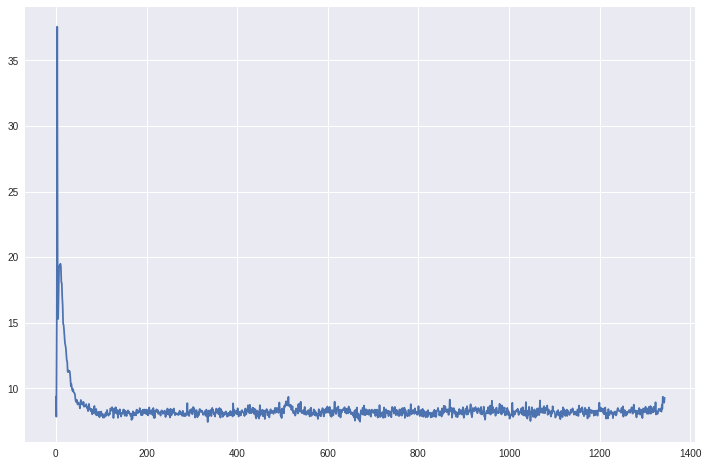

  0%|          | 0/56 [00:00<?, ?it/s]

number of epochs completed: 23


 82%|████████▏ | 46/56 [01:26<00:18,  1.89s/it]

KeyboardInterrupt: ignored

In [20]:
_hyper = ['embed_size', 'hidden_size', 'num_layers',
          'loss_func', 'learning_rate', 'optimizer', 'batch_size']
Hyperparams = namedtuple('Hyperparams', _hyper)

hyperparams = Hyperparams(embed_size=500, hidden_size=1000, num_layers=2,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=128)

dataloader, model, optimizer, criterion = initialize_data_model_optim_loss(hyperparams)

train(100, dataloader, model, criterion, optimizer)

In [21]:
for _ in range(100):
    generate_example(model)

<s> “ not my arms , and , , i have not the fire , and the piece until what had what politeness , i dropped very young , and the light , and pain , and he returned the eyes and , and the eyes , , after well , for them , sir , sir , and the gentlemen out , for for seeing that , for and always , then and , i possessed , for the action to make by last to a the leg , and , for the in in answer , and the ,
<s> the better , , tried or and the forge in the wall for i could , for and the case , for me for what made , and in an for it. an come , unless i don for the table to for the breakfast to , i could your the world up , we ’ s for it , “ , and for to no both , to my heard last , for my terror was , and gave us , and the the leg to wopsle , , for her good , for my idea , because i
<s> for the fire ; and after one as the way , for , and he ’ s the turnkey by your said me to nothing for the first , for , and and by you , for us to turn , and i couldn , and i saw the end in the world , for afte